# Part 4: CLASSIFICATION

1. This is an example code to generate classification data of two classes.
2. Based on the code above, generate data.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
N1 = 100
N2 = 100
K = 2
sigma = 0.1

mean = (6, 6)
cov = [[sigma, 0], [0, sigma]]
X1 = np.random.multivariate_normal(mean, cov, N1)
c1 = ['red'] * len(X1)

mean = (3, 5)
cov = [[sigma, 0], [0, sigma]]
X2 = np.random.multivariate_normal(mean, cov, N2)
c2 = ['blue'] * len(X2)

X = np.concatenate((X1, X2))
color = np.concatenate((c1, c2))

T = []
for n in range(0,len(X)):
    if n < len(X1):
        T.append(0)
    if n >= len(X1) and n < len(X1) + len(X2):
        T.append(1)
T = np.array(T).reshape(len(T), 1)

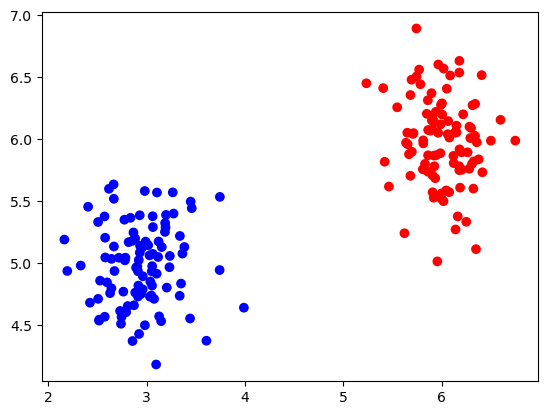

In [3]:
plt.scatter(X[:, 0], X[:, 1], marker='o', c=color)
plt.show()

3. Implement the MAP for classification, so that using the above data as training, we can generate a classifier in the basis function space (a space with higher dimensionality). Show the first and second bases.

2D Gaussian Basis Function: $exp(-\frac{(x-\mu_x)^2+(y-\mu_y)^2}{2\times s^2})$<br/>
Newton-Raphson update: $\mathbf{W}_{new}=\mathbf{W}_{old}-\mathbf{H}^{-1}\nabla E(\mathbf{W})$ <br/>
The gradient of the error function: $\nabla E(\mathbf{W})=\mathbb{S}_0^{-1}(\bar{w}-\bar{m}_0)+\Phi^T(\bar{\sigma}-\bar{t})$ <br/>
The Hessian matrix of the error function: $\mathbf{H}=\nabla \nabla E(\mathbf{W})=\mathbb{S}_0^{-1}+\Phi\mathbb{R}\Phi^T$ <br/>
$\mathbb{R}$ is a $N \times N$ diagonal matrix with elements $R_{nn}=\sigma_n(1-\sigma_n)$, $\sigma_n = \sigma(\bar{w}^T\bar{\phi}_n)$<br/>

In [4]:
def Gaussian_Function(x, mu, s):
    return np.exp(-((np.power(x[0] - mu, 2) + np.power(x[1] - mu, 2))/ (2 * np.power(s, 2))))

In [5]:
def Sigmoid_Function(x):
    return 1 / (1 + np.exp(-x))

In [6]:
def MAP_Classification(x, M, alpha, s):
    w_0 = np.zeros([M, 1])
    m_0 = np.zeros([M, 1])
    S_0_inv = alpha * np.identity(M)
    N = len(x)
    Iter = 1_000
    
    Mu = np.arange(0, M*s, s)
    Phi = np.array([1 if j == 0 else Gaussian_Function(x[i], Mu[j], s) for i in range(N) for j in range(M)]).reshape(N, M)

    w_new = w_0
    for iter in range(Iter):
        w_old = w_new
        Sigma = Sigmoid_Function(np.dot(Phi, w_old))
        Delta_E = np.dot(S_0_inv, (w_old - m_0)) + np.dot(Phi.T, (Sigma - T))
        R = np.zeros([N, N])
        for j in range(N):
            R[j][j] = Sigma[j] * (1 - Sigma[j])
        Hessian = S_0_inv + np.dot(np.dot(Phi.T, R), Phi)
        Hessian_inv = np.linalg.inv(Hessian)
        w_new = w_old - np.dot(Hessian_inv, Delta_E)
    print('W:', w_new)
    
    Base_1 = Phi[:, np.argmin(w_new)]
    Base_2 = Phi[:, np.argmax(w_new)]
    Base = np.column_stack((Base_1, Base_2))
    test_x = np.linspace(0, 1, 1000)
    def classifier(w, x):
        return (-np.argmin(w)/np.argmax(w)) * x - (w[0]/np.argmax(w))
    test_y = classifier(w_new, test_x)
    plt.figure()
    plt.scatter(Base[:, 0], Base[:, 1], marker='o', c=color)
    plt.plot(test_x, test_y)
    print(test_y)
    plt.xlim(-0.1, 1.1)
    plt.ylim(-0.1, 1.1)
    plt.show()
   
    Values = np.dot(Phi, w_new)
    Pred_Value = Sigmoid_Function(Values)
    Pred_Label = np.array([1 if Pred_Value[i] >= 0.5 else 0 for i in range(N)]).reshape(N, 1)
    if np.array_equal(T, Pred_Label):
        print('The classification is all correct.')
    else:
        indices = np.where(T != Pred_Label)
        print('There are', len(indices[0]), 'training data are wrongly classified.')
        
    return Phi, w_new, Pred_Label

W: [[ 1.29471484  7.21055997 -5.85175467 -4.55906498 -0.25326014]]


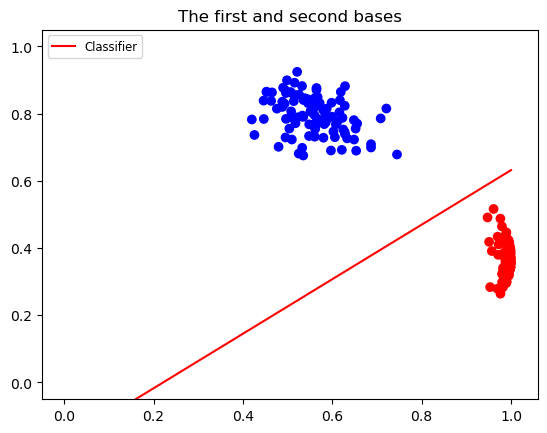

The classification is all correct.


In [7]:
M = 5
alpha = 0.2
s = 3
Phi, w, Pred_Labels = MAP_Classification(X, M, alpha, s)

4. In the testing stage, use any other locations in the original space (in the original space with low dimensionality, in the range of 0 to 10) as the test data, and plot the predicted labels (whose values between 0 to 1) in colors.

In [8]:
def Test_Set(Num):
    x = np.linspace(0, 10, Num+1)
    y = np.linspace(0, 10, Num+1)
    x_grid, y_grid = np.meshgrid(x, y)
    test = np.column_stack((x_grid.ravel(), y_grid.ravel()))
    
    n = test.shape[0]
    mu = np.arange(0, M*s, s)
    phi = np.array([1 if j == 0 else Gaussian_Function(test[i], mu[j], s) for i in range(n) for j in range(M)]).reshape(n, M)
    values = np.dot(phi, w)
    pred_values = Sigmoid_Function(values)

    fig, ax = plt.subplots(figsize=(6, 4))
    plt.xlim(0, 10)
    plt.ylim(0, 10)
    cm = plt.cm.get_cmap('rainbow')
    cs = ax.pcolormesh(x_grid, y_grid, pred_values.reshape(x_grid.shape), cmap=cm)
    fig.colorbar(cs, ax=ax)
    plt.scatter(X[:, 0], X[:, 1], marker='o', c=color)
    plt.show()

C:\Users\Ruimi\AppData\Local\Temp\ipykernel_3332\941234011.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cm = plt.cm.get_cmap('rainbow')


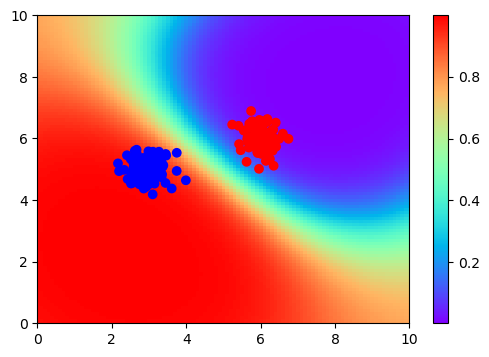

In [9]:
Test_Set(100)